In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

data_dir = 'hymenoptera_data'
image_dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                     data_transforms[x])
                 for x in ['train', 'val']}


dataloder = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size=4,
                                             shuffle=True, num_workers=4)
             for x in ['train', 'val']}

dataset_size = {x: len(image_dataset[x]) 
                for x in ['train', 'val']}
class_name = image_dataset['train'].classes

use_gpu = torch.cuda.is_available()

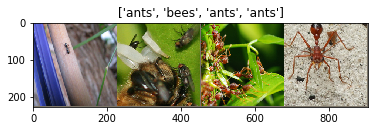

In [3]:
def imshow(inp, title=None):
    """Imsow for Tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
# Get a batch of training data
inputs, classes = next(iter(dataloder['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_name[x] for x in classes])

## Training the Model

* Scheduling the learning rate
* Saving the best model

Scheduler is an LR scheduler object from torch.optim.lr_scheduler

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloder[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects / dataset_size[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloder['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_name[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

## Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

print(model_ft)

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1805 Acc: 0.6680
val Loss: 0.0618 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.1695 Acc: 0.7500
val Loss: 0.0662 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.1521 Acc: 0.7541
val Loss: 0.0684 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.1399 Acc: 0.7828
val Loss: 0.0861 Acc: 0.8562

Epoch 4/24
----------
train Loss: 0.0956 Acc: 0.8402
val Loss: 0.0594 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.1467 Acc: 0.7582
val Loss: 0.0497 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.1388 Acc: 0.8115
val Loss: 0.0719 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.0961 Acc: 0.8279
val Loss: 0.1109 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.0886 Acc: 0.8361
val Loss: 0.0539 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.0840 Acc: 0.8402
val Loss: 0.0607 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.1123 Acc: 0.8033
val Loss: 0.0561 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.0597 Acc: 0.8893
val Loss: 0.0580 Acc: 0.9150

Ep

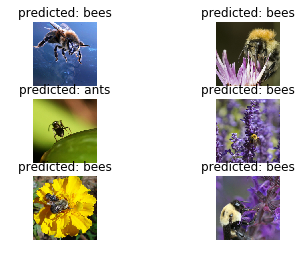

In [8]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

In [9]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [10]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1545 Acc: 0.6475
val Loss: 0.0880 Acc: 0.8170

Epoch 1/24
----------
train Loss: 0.1281 Acc: 0.7459
val Loss: 0.0425 Acc: 0.9673

Epoch 2/24
----------
train Loss: 0.1043 Acc: 0.8115
val Loss: 0.0405 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.0870 Acc: 0.8566
val Loss: 0.0635 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.1238 Acc: 0.7910
val Loss: 0.0471 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.1289 Acc: 0.8033
val Loss: 0.0604 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.1187 Acc: 0.8074
val Loss: 0.0555 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.0963 Acc: 0.8443
val Loss: 0.0478 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.0811 Acc: 0.8607
val Loss: 0.0392 Acc: 0.9608

Epoch 9/24
----------
train Loss: 0.1058 Acc: 0.8279
val Loss: 0.0434 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.0884 Acc: 0.8320
val Loss: 0.0436 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.0666 Acc: 0.8893
val Loss: 0.0427 Acc: 0.9477

Ep

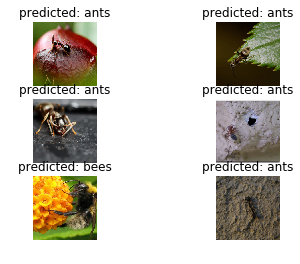

In [11]:
visualize_model(model_conv)